In [1]:
import pandas as pd
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import glob

import string
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
tweet_files = glob.glob('../Data/Tweets_scraped_2000_*.csv')
news_files = glob.glob('../Data/corona_news_scraped_on_2*.csv')

In [3]:
all_news = pd.concat([pd.read_csv(f) for f in news_files],ignore_index =True)
all_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 2 columns):
datetime    339 non-null object
text        339 non-null object
dtypes: object(2)
memory usage: 5.4+ KB


In [4]:
all_tweets = pd.concat([pd.read_csv(f) for f in tweet_files],ignore_index =True)
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
geo               4 non-null object
tweet             4000 non-null object
user_handle       4000 non-null object
location          2895 non-null object
cleaned_tweets    3998 non-null object
dtypes: object(5)
memory usage: 156.3+ KB


In [5]:
all_tweets.drop(columns=['geo','tweet','user_handle','location'],axis = 1,inplace=True)
all_tweets.rename(columns={'cleaned_tweets':'text'},inplace=True)
all_tweets.head()

,text
0,punjab cm captain amarinder singh has sought ...
1,excited to announce that we have launched cov...
2,this corona is going to teach us a lot of thi...
3,public health expes including dr anthony fauc...
4,a spencer thank you everyone for your incredi...


In [6]:
documents = pd.DataFrame()
documents['text'] = pd.concat([all_news.text,all_tweets.text],axis =0 ,ignore_index=True)
documents.head()

,text
0,"2 new positive cases reported, positive cases ..."
1,"23-year old, with the recent travel history to..."
2,Coronavirus lockdown in Maharashtra: What's ex...
3,Visual from Srinagar as the complete lockdown ...
4,QuoteThe total number of positive Coronavirus...


In [7]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 1 columns):
text    4337 non-null object
dtypes: object(1)
memory usage: 34.0+ KB


In [8]:
nlp = spacy.load('en_core_web_sm')

### Cleaning Data for NLP

In [9]:
import re
# Remove HTML Tags
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free_text = soup.get_text()
    return html_free_text

# Remove Punctuations
def punctuation_remover(text):
    punctuation_free_text = " ".join([word for word in text if word \
                                    not in string.punctuation])
    return punctuation_free_text


# Stop Word Removal
cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
def stop_words_remover(text):
#     text = text.lower().split()
    words = [word for word in text if \
             word not in cached_stop_words]
    return words

# Convert to lower case
def convert_to_lowercase(tokens):
    low = []
    for tok in tokens:
        low.append(tok.lower().strip())
    return low

# Lemmatization
def lemmatize_words(text):
    words = nlp(str(text))
    return [word.lemma_ for word in words if word.lemma_ != '-PRON-']  

def replace_urls(tokens):
    re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", tokens)
    return tokens


def remove_short_strings(text, length):
    array = []
    for word in text:
        if len(word) > length:
            array.append(word)
    return array

In [10]:
tokenized_documents = documents.copy()
tokenized_documents['text'] = tokenized_documents.text.astype(str)

In [11]:
def clean_text_for_tasks(text, for_pos_tagging = False):
    cleaned_text = remove_html(text)
    cleaned_text = replace_urls(cleaned_text)
    cleaned_text = word_tokenize(cleaned_text)
   
    
    if for_pos_tagging is False:
        cleaned_text = convert_to_lowercase(cleaned_text)
        cleaned_text = stop_words_remover(cleaned_text)
        cleaned_text = lemmatize_words(cleaned_text)
    cleaned_text = remove_short_strings(cleaned_text,2)
    cleaned_text = punctuation_remover(cleaned_text)
    
    return cleaned_text

In [12]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

tokenized_documents['cleaned_text'] = tokenized_documents.text.progress_apply(clean_text_for_tasks)
# tokenized_documents['cleaned_text'] = tokenized_documents.text.parallel_apply(clean_text_for_tasks,axis = 1 )

In [13]:
tokenized_documents.head()

,text,cleaned_text
0,"2 new positive cases reported, positive cases ...",new positive case report positive case gujarat...
1,"23-year old, with the recent travel history to...",23-year old recent travel history test positiv...
2,Coronavirus lockdown in Maharashtra: What's ex...,coronavirus lockdown maharashtra exclude restr...
3,Visual from Srinagar as the complete lockdown ...,visual srinagar complete lockdown impose jammu...
4,QuoteThe total number of positive Coronavirus...,quotethe total number positive coronavirus cas...


### Using Linguistic Features such as Named Entity Recognition and Parts-of-Speech

We will use these features to gain more insights into the most talked about entities. Which will allow us 
to further explore into those topics.

In [14]:
tokenized_documents[200:300].head(10)

,text,cleaned_text
200,Social distancing in Uttarkashi,social distance uttarkashi
201,Ram Janmabhoomi Teerath trust postpones it’s s...,ram janmabhoomi teerath trust postpone schedul...
202,Ram Janmabhoomi Teerath trust postpones it’s s...,ram janmabhoomi teerath trust postpone schedul...
203,Chennai: Congress MLA A Johnkumar booked for v...,chennai congress mla johnkumar book violate lo...
204,DPIIT sets up a Control Room to monitor the st...,dpiit set control room monitor status transpor...
205,All stages of NEET PG 2020 counselling postpon...,stage neet 2020 counselling postpone due covid...
206,Kashmir reports first Covid-19 death as 65-yea...,kashmir report first covid-19 death 65-year ol...
207,2 new positive cases of Coronavirus in Mumbai ...,new positive case coronavirus mumbai thane til...
208,Tracking Covid-19,tracking covid-19
209,Resident Doctor's Association of Delhi AIIMS w...,resident doctor association delhi aiim write h...


In [15]:
from spacy import displacy

doc_1 = nlp(tokenized_documents.iloc[207].text)
displacy.render(doc_1, style="ent")

In [16]:
doc_1 = nlp(tokenized_documents.iloc[3050].text)
displacy.render(doc_1, style="ent")

#### We can see that spacy does not recognize the Corona Virus 

In [17]:
# sample_texts = tokenized_documents[200:300].text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))
# sample_texts = tokenized_documents[200:300].cleaned_text
training_sample_data = tokenized_documents.sample(10,random_state=10)
for  text in training_sample_data.text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

#     print(test_doc)
#     print()
#     print()
#     for token in test_doc:
#         print(token.text, token.dep_, token.head.text, token.head.pos_)
#     print()
#     print()
#     for entity in test_doc.ents:
#         print(entity.text,entity.label_)

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


#### We will retrain the model to detect few of these entities

In [18]:
#To-DO

In [19]:
# from spacy.symbols import nsubj, VERB,NORP, NOUN, PRON

# verbs = set()
# for possible_subject in test_doc:
#     if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
#         verbs.add(possible_subject.head)
# print(verbs)

In [20]:
# from spacy import displacy
# displacy.render(test_doc, style="ent")

### Find POS tags for each document like NOUN and PROPN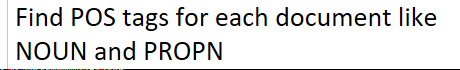

In [21]:
docs_for_pos = tokenized_documents.copy()
docs_for_pos['cleaned_for_pos_tagging'] = tokenized_documents.text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))   

In [22]:
def get_pos_tags():

    INTERTESTED_POS_TAGS = ['NOUN' , 'PROPN' ]
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows()):
        pos= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
    #     tokenized = nlp(text)
        for token in tokenized:
            if token.pos_ in INTERTESTED_POS_TAGS:
    #                 print(token.text,token.pos_)
                pos['word'] = token.text
                pos['pos_tag'] = token.pos_
                tags.append(pos)
    return tags

In [23]:
# from joblib import Parallel, delayed
# tags = Parallel(n_jobs=8,backend='multiprocessing')(
#             delayed(get_pos_tags())
# #         )
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

# tags = docs_for_pos.parallel_apply(get_pos_tags,axis =1 )
tags = get_pos_tags()

In [24]:
tags_df = pd.DataFrame(tags)
tags_df.head()

,pos_tag,word
0,NOUN,secretary
1,NOUN,secretary
2,NOUN,secretary
3,NOUN,secretary
4,NOUN,secretary


In [25]:
tags_size = tags_df.groupby(['pos_tag', 'word']).size()

In [26]:
tags_noun = tags_df.loc[tags_df.pos_tag == 'NOUN']
tags_noun.head()

,pos_tag,word
0,NOUN,secretary
1,NOUN,secretary
2,NOUN,secretary
3,NOUN,secretary
4,NOUN,secretary


In [47]:
from pandas.core.common import flatten

all_noun_words =list(flatten(tags_noun.word.values))

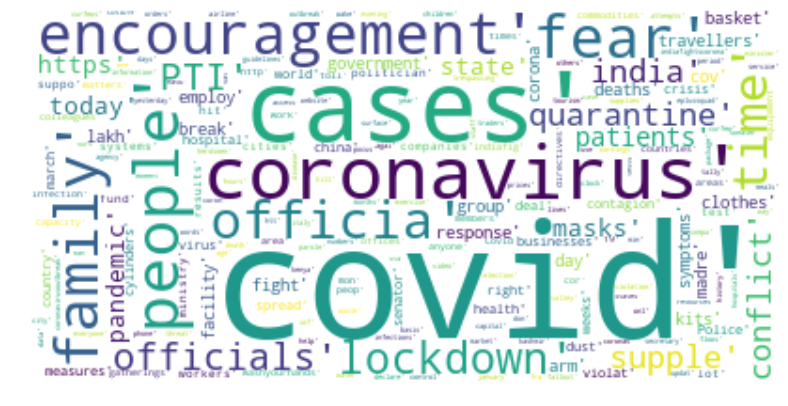

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline


wordcloud = WordCloud(background_color = 'white',collocations=False).generate(str(all_noun_words))
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
from collections import Counter

noun_counts = Counter(tags_df.word)

In [30]:
print(noun_counts.most_common(30))

[('covid', 1908), ('cases', 440), ('coronavirus', 424), ('people', 277), ('encouragement', 260), ('family', 256), ('fear', 248), ('officia', 225), ('time', 208), ('lockdown', 193), ('officials', 185), ('quarantine', 177), ('PTI', 174), ('supple', 172), ('conflict', 168), ('india', 162), ('patients', 160), ('https', 144), ('today', 135), ('masks', 134), ('pandemic', 127), ('state', 121), ('government', 118), ('corona', 117), ('travellers', 115), ('response', 104), ('Monday', 99), ('break', 99), ('fight', 98), ('ANI', 96)]


In [31]:
most_common_nouns = noun_counts.most_common(40)
for i in range(3):
    most_common_nouns.pop(0)

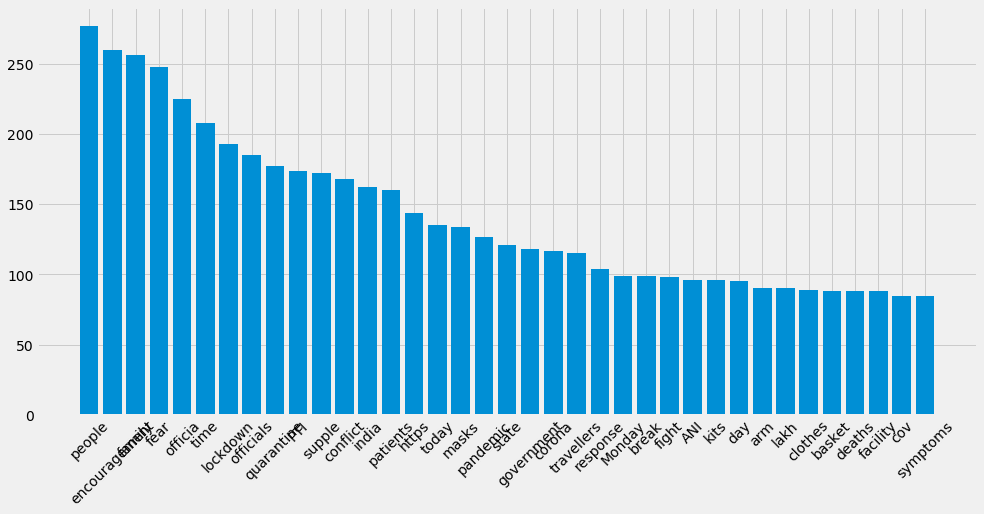

In [32]:
plt.style.use('fivethirtyeight')
# plt.title('Most Commonly Used NOUNs')
plt.figure(figsize=(15,7))
plt.xticks(rotation='45')
plt.bar(*zip(*most_common_nouns))
plt.show()


### Now, let us find the most common occuring Entities

In [33]:
def get_entity_tags():

    INTERTESTED_ENTITY_TAGS = ['NORP' , 'GPE' ,'ORG', 'PRODUCT', 'LOC', 'PERSON']
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows()):
        entity= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
        for ent in tokenized.ents:
            if ent.label_ in INTERTESTED_ENTITY_TAGS:
                entity['word'] = ent.text
                entity['entity_tag'] = ent.label_
                tags.append(entity)
    return tags

In [34]:
entities = get_entity_tags()

In [35]:
# entities

In [36]:
entities_df = pd.DataFrame(entities)

In [37]:
entity_counts = Counter(entities_df.word)

In [50]:
entity_counts.most_common(30)

[('India', 55),
 ('China', 52),
 ('PTI', 31),
 ('Trump', 21),
 ('Delhi', 20),
 ('Coronavirus', 20),
 ('WHO', 20),
 ('ICMR', 19),
 ('New York City', 16),
 ('Reuters', 15),
 ('Bihar', 15),
 ('McDonald', 14),
 ('Gujarat', 13),
 ('Maharashtra', 13),
 ('american', 13),
 ('ANI', 12),
 ('Kashmir', 12),
 ('POSOCO', 12),
 ('Punjab', 11),
 ('Narendra Modi', 11),
 ('Chhatarpur', 11),
 ('Andrew Ganj', 10),
 ('Wuhan', 9),
 ('Bhopal Lockdown', 9),
 ('Modi', 8),
 ('Tunisia', 8),
 ('SpiceJet', 8),
 ('Lindner', 8),
 ('china', 8),
 ('AFP', 7)]

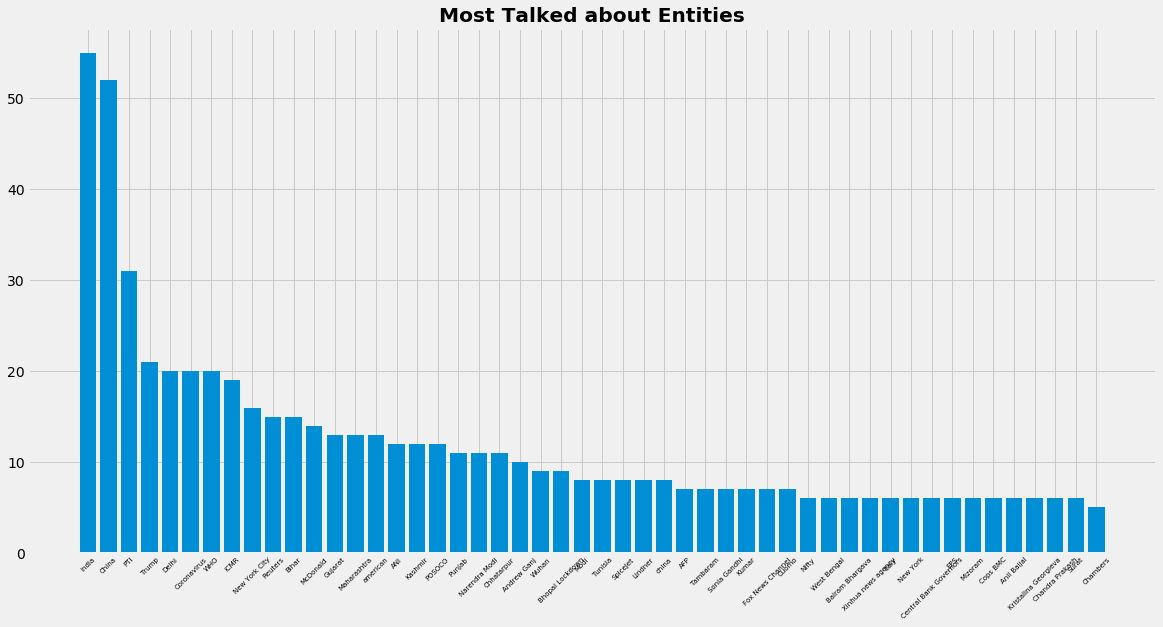

In [39]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18,9))
plt.xticks(rotation='45',fontsize = 7)
plt.bar(*zip(*entity_counts.most_common(50)))
plt.title(label = 'Most Talked about Entities',fontweight = 'bold')
plt.show()


#### Let's find some documents swith the Top enities that we found above

In [40]:
entity_filtered_docs = docs_for_pos[(docs_for_pos.cleaned_for_pos_tagging.str.contains('India')) 
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('Trump'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('ICMR'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('WHO'))]

In [41]:
entity_filtered_docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 10 to 338
Data columns (total 3 columns):
text                       67 non-null object
cleaned_text               67 non-null object
cleaned_for_pos_tagging    67 non-null object
dtypes: object(3)
memory usage: 2.1+ KB


In [42]:
for  text in entity_filtered_docs.sample(50).text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


---------
